<a href="https://colab.research.google.com/github/Kobrun4ik/Cheminformatics/blob/main/Kobrin_Cheminformatics_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. load dataset in a Jupyter notebook and extract relevant column to be processed

In [1]:
import pandas as pd

data = pd.read_csv("/content/compounds.csv", delimiter=";")

smiles_list = data['smiles'].tolist()
compound_names = data['name'].tolist()

print(data)

                                                name  \
0    Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate   
1  (S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)prop...   
2                                        Etilevodopa   
3                                        Foslevodopa   
4                                         Melevodopa   
5                                    L-DOPA (sodium)   
6                      Tyrosine, 3-hydroxy-O-methyl-   
7                                  3-Methoxytyrosine   

                                  smiles  \
0         CCOC(=O)C(CC1=CC(=C(C=C1)O)O)N   
1       COC(=O)C(CC1=CC(=C(C=C1)O)O)N.Cl   
2         CCOC(=O)C(CC1=CC(=C(C=C1)O)O)N   
3  C1=CC(=C(C=C1CC(C(=O)O)N)O)OP(=O)(O)O   
4          COC(=O)C(CC1=CC(=C(C=C1)O)O)N   
5      C1=CC(=C(C=C1CC(C(=O)O)N)O)O.[Na]   
6          COC1=C(C=C(C=C1)CC(C(=O)O)N)O   
7          COC1=C(C=CC(=C1)CC(C(=O)O)N)O   

                                              pubmed  
0  https://pubchem.ncbi.nlm.nih.gov/compoun

2. compute molecular fingerprints for each compound

In [2]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 42.9 MB/s eta 0:00:00


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) for mol in molecules]

print(f"Generated {len(fingerprints)} fingerprints.")

Generated 8 fingerprints.


* Display molecules

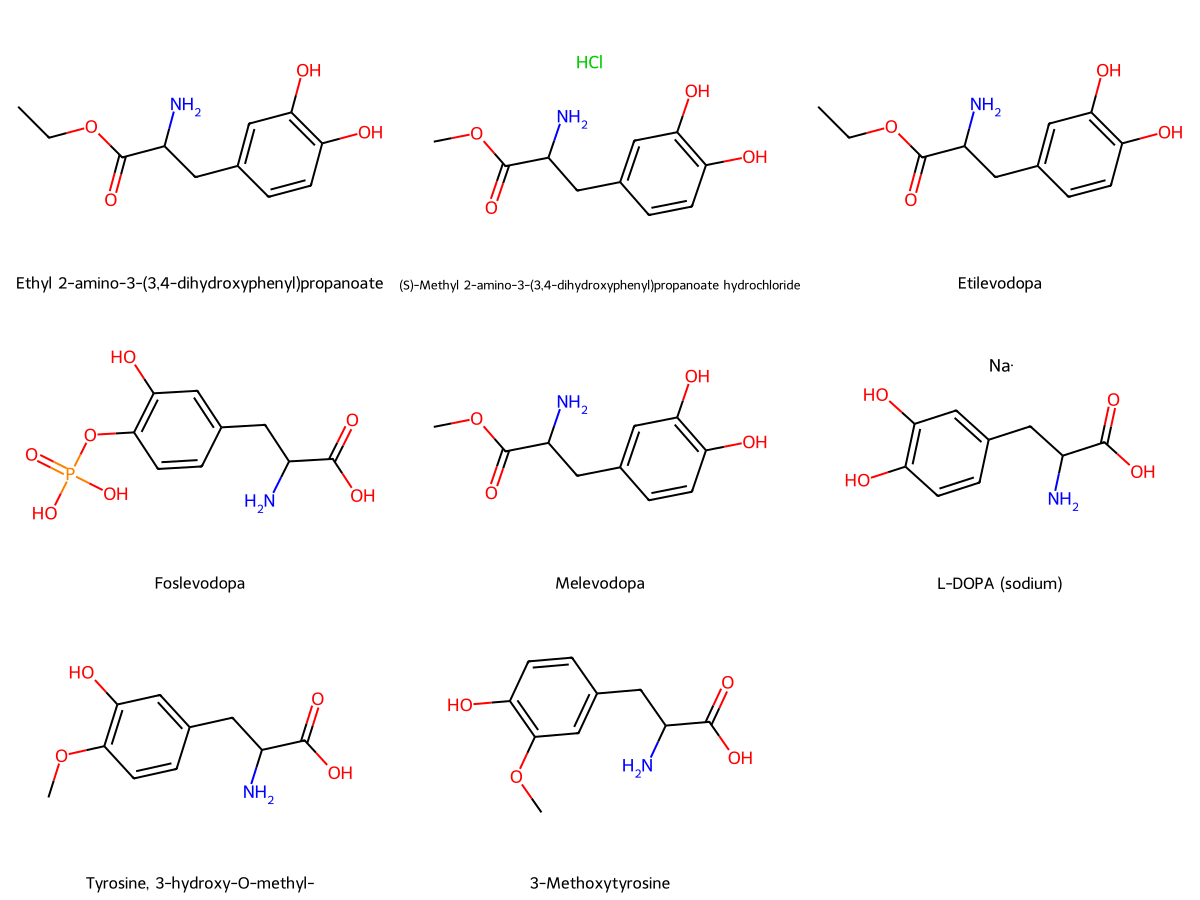

In [4]:
from rdkit.Chem import Draw
from IPython.display import display

img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(400, 300), legends=compound_names)

display(img)

3. compute Tanimoto similarity measure for each pair of compound x reference compound

In [5]:
import numpy as np
import pandas as pd
from rdkit.DataStructs import TanimotoSimilarity

num_compounds = len(fingerprints)
similarity_matrix = np.zeros((num_compounds, num_compounds))

# vypocitem jen pulku, protoze matice je symetricka
for i in range(num_compounds):
    for j in range(i, num_compounds):
        similarity = TanimotoSimilarity(fingerprints[i], fingerprints[j])
        similarity_matrix[j, i] = similarity

df = pd.DataFrame(similarity_matrix, index=compound_names, columns=compound_names)

display(df.style.background_gradient(cmap='Blues').format("{:.2f}"))

,"Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate","(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride",Etilevodopa,Foslevodopa,Melevodopa,L-DOPA (sodium),"Tyrosine, 3-hydroxy-O-methyl-",3-Methoxytyrosine
"Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate",1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride",0.73,1.00,0.00,0.00,0.00,0.00,0.00,0.00
Etilevodopa,1.00,0.73,1.00,0.00,0.00,0.00,0.00,0.00
Foslevodopa,0.45,0.45,0.45,1.00,0.00,0.00,0.00,0.00
Melevodopa,0.75,0.97,0.75,0.46,1.00,0.00,0.00,0.00
L-DOPA (sodium),0.62,0.62,0.62,0.60,0.64,1.00,0.00,0.00
"Tyrosine, 3-hydroxy-O-methyl-",0.51,0.55,0.51,0.68,0.56,0.65,1.00,0.00
3-Methoxytyrosine,0.51,0.55,0.51,0.57,0.56,0.65,0.78,1.00


4. provide sorting, report top 3 hits and discuss your results

In [6]:
similarity_pairs = []

for i in range(1, num_compounds):
    for j in range(i):
        similarity_pairs.append((i, j, similarity_matrix[i, j]))

sorted_pairs = sorted(similarity_pairs, key=lambda x: x[2], reverse=True)
top_3_similarities = sorted_pairs[:3]

for i, j, similarity in top_3_similarities:
    print(f"Similarity: {similarity:.2f}: {compound_names[i]} |X| {compound_names[j]}")

Similarity: 1.00: Etilevodopa |X| Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate
Similarity: 0.97: Melevodopa |X| (S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride
Similarity: 0.78: 3-Methoxytyrosine |X| Tyrosine, 3-hydroxy-O-methyl-


Vypada ze Etilevodopa a Ethyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate maji stejnou strukturu.

(S)-Methyl 2-amino-3-(3,4-dihydroxyphenyl)propanoate hydrochloride je hydrochloridem Melevedopy




BONUS: implement N similarity measures (such as Tanimoto, Dice, Euclidean) x M (fingerprints) and compare them in a graphical form

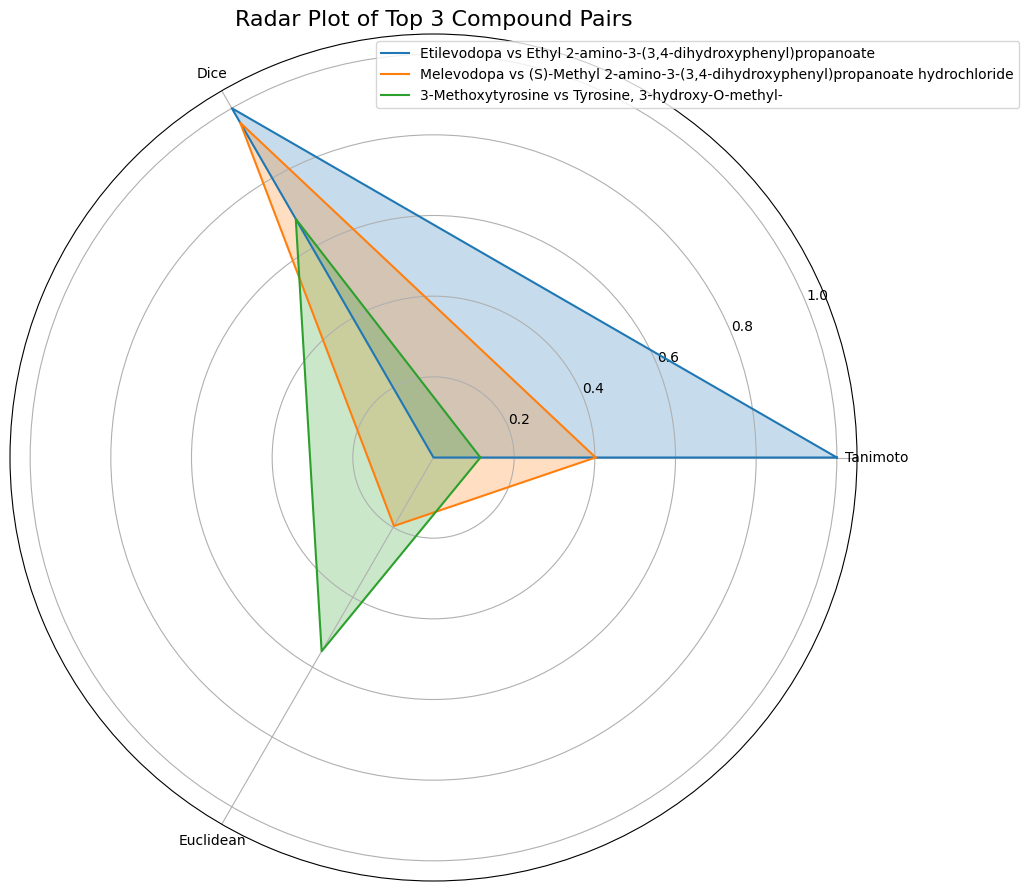

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.DataStructs import DiceSimilarity
from scipy.spatial.distance import euclidean

# Compute Dice similarities
dice_similarity_matrix = np.zeros((num_compounds, num_compounds))

for i in range(num_compounds):
    for j in range(i, num_compounds):
        similarity = DiceSimilarity(fingerprints[i], fingerprints[j])
        dice_similarity_matrix[j, i] = similarity

# Extract lower triangle (excluding diagonal) for both Tanimoto and Dice
tanimoto_similarities = []
dice_similarities = []

for i in range(1, num_compounds):
    for j in range(i):
        tanimoto_similarities.append(similarity_matrix[i, j])
        dice_similarities.append(dice_similarity_matrix[i, j])

# Compute Euclidean distances
euclidean_distances = []
for i in range(1, num_compounds):
    for j in range(i):
        fp1 = np.array(fingerprints[i])
        fp2 = np.array(fingerprints[j])
        euclidean_distances.append(euclidean(fp1, fp2))

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Tanimoto": tanimoto_similarities,
    "Dice": dice_similarities,
    "Euclidean": euclidean_distances
})

# # Plot pairwise relationships between Tanimoto, Dice, and Euclidean
# sns.pairplot(comparison_df, diag_kind="kde", markers="o", plot_kws={"alpha": 0.7})
# plt.suptitle("Pairwise Comparison of Similarity Measures", y=1.02, fontsize=16)
# plt.show()



from math import pi

# Normalize values for radar plot
comparison_df_norm = (comparison_df - comparison_df.min()) / (comparison_df.max() - comparison_df.min())

# Add compound pair labels
comparison_df_norm['Compound Pair'] = [f"{compound_names[i]} vs {compound_names[j]}" for i in range(1, num_compounds) for j in range(i)]

# Select top 5 pairs for radar plot
top_3_pairs = comparison_df_norm.nlargest(3, 'Tanimoto')

# Prepare data for radar plot
categories = ["Tanimoto", "Dice", "Euclidean"]
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw={'projection': 'polar'})

# Plot each pair
for i, row in top_3_pairs.iterrows():
    values = row[categories].tolist()
    values += values[:1]  # Close the radar chart loop
    ax.plot(angles, values, label=row['Compound Pair'])
    ax.fill(angles, values, alpha=0.25)

# Add labels and legend
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Radar Plot of Top 3 Compound Pairs", fontsize=16)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0))
plt.show()